In [1]:
#general data-science imports
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#interaction with environment
import subprocess as sp
import glob

#bio
from Bio import SeqIO
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio.Seq import reverse_complement as rc
import pysam

#data-compression
import gzip


In [2]:
#Get list of all raw files and transform it into an array of paired files

list_of_files = glob.glob("../data/raw/*.fastq.gz")

list_of_files.sort()

file_array = np.array([list_of_files]).reshape(3, 2)

file_array

array([['../data/raw/EL-test2_S1_L001_R1_001.fastq.gz',
        '../data/raw/EL-test2_S1_L001_R2_001.fastq.gz'],
       ['../data/raw/GR-test2_S2_L001_R1_001.fastq.gz',
        '../data/raw/GR-test2_S2_L001_R2_001.fastq.gz'],
       ['../data/raw/RN-test2_S3_L001_R1_001.fastq.gz',
        '../data/raw/RN-test2_S3_L001_R2_001.fastq.gz']], dtype='<U44')

In [3]:
# Make a dictionary with the ID as key, and paired files as entry. While looping through the file-array, verify
# that all the ID's of paired files match, and that there are no duplicate IDs outside of paired files.

def file_dict_make(file_array, location = "../data/raw/"):
    
    f_dict = {}
    for pair in file_array:
        id1 = pair[0].lstrip(location)[0: 2]
        id2 = pair[1].lstrip(location)[0: 2]
        if id1 != id2:
            raise NameError("ID for {0} and {1} not matching, verify alignement in array".format(pair[0], pair[1]))
        elif id1 in f_dict:
            raise NameError("duplicate ID {}, verify file-names!".format(id1))
        else:
            f_dict[id1] = pair
    
    return(f_dict)


file_dict = file_dict_make(file_array)
file_dict

{'EL': array(['../data/raw/EL-test2_S1_L001_R1_001.fastq.gz',
        '../data/raw/EL-test2_S1_L001_R2_001.fastq.gz'], dtype='<U44'),
 'GR': array(['../data/raw/GR-test2_S2_L001_R1_001.fastq.gz',
        '../data/raw/GR-test2_S2_L001_R2_001.fastq.gz'], dtype='<U44'),
 'RN': array(['../data/raw/RN-test2_S3_L001_R1_001.fastq.gz',
        '../data/raw/RN-test2_S3_L001_R2_001.fastq.gz'], dtype='<U44')}

In [71]:
#Merge reads with FLASH. Output files go to the data/merged subfolder

for key in file_dict:
    command = "flash {0} {1} -M 250 -o {2}_ -d ../data/merged/".format(file_dict[key][0], file_dict[key][1], key)
    sp.run(command, capture_output = True, shell = True)

In [73]:
#let's have a look at the histogramms:

In [5]:
histos = glob.glob("../data/merged/*.hist")

histos

['../data/merged/RN_.hist',
 '../data/merged/EL_.hist',
 '../data/merged/GR_.hist']

In [6]:
dict_histos = {}
for hist in histos:
    df_hist = pd.read_csv(hist, sep = "\t", index_col = 0,
                          header = None, names = ["len", "count"])
    dict_histos[hist[-8 : -6]] = df_hist

dict_histos["EL"]

,count
len,
39,1
40,18
41,1
46,1
47,1
...,...
488,4
489,37
490,8


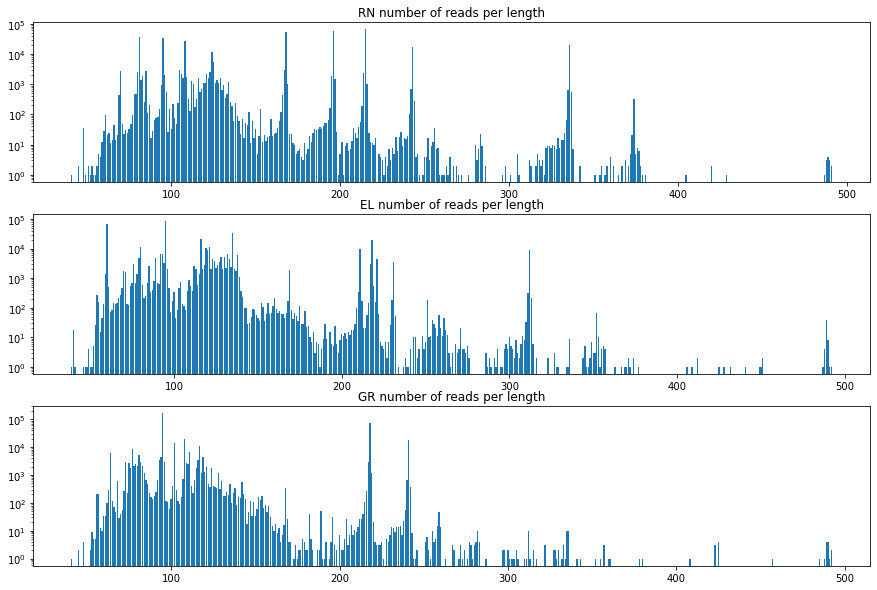

In [7]:
fig, axs = plt.subplots(3, 1, figsize =(15, 10))

for ax, key in zip(axs.flatten(), dict_histos):
    ax.bar(x = dict_histos[key].index, height = dict_histos[key]["count"])
    ax.set_title(key + " number of reads per length")
    ax.set_yscale("log")


In [8]:
glob.glob("../data/merged/*extendedFrags.fastq")

['../data/merged/GR_.extendedFrags.fastq',
 '../data/merged/RN_.extendedFrags.fastq',
 '../data/merged/EL_.extendedFrags.fastq']

In [2]:
# import referencebarcodes

reference = "../data/reference/references.xlsx"

df_temp = pd.read_excel(reference, sheet_name = 1, usecols = ["Barcodes_col", "Coordinate_col"],
                                 index_col = "Barcodes_col").loc[:,"Coordinate_col"]
barcode_col_dict = df_temp.to_dict()


df_temp = pd.read_excel(reference, sheet_name = 1, usecols = ["Barcodes_row", "Coordinate_row"],
                                 index_col = "Barcodes_row", nrows = 16).loc[:,"Coordinate_row"]
barcode_row_dict = df_temp.to_dict()

print(barcode_col_dict, barcode_row_dict)


{'TCGCCTTA': 1, 'CTAGTACG': 2, 'TTCTGCCT': 3, 'GCTCAGGA': 4, 'AGGAGTCC': 5, 'CATGCCTA': 6, 'GTAGAGAG': 7, 'CAGCCTCG': 8, 'TGCCTCTT': 9, 'TCCTCTAC': 10, 'TCATGAGC': 11, 'CCTGAGAT': 12, 'TAGCGAGT': 13, 'GTAGCTCC': 14, 'TACTACGC': 15, 'AGGCTCCG': 16, 'GCAGCGTA': 17, 'CTGCGCAT': 18, 'GAGCGCTA': 19, 'CGCTCAGT': 20, 'GTCTTAGG': 21, 'ACTGATCG': 22, 'TAGCTGCA': 23, 'GACGTCGA': 24} {'CTCTCTAT': 'A', 'TATCCTCT': 'B', 'GTAAGGAG': 'C', 'ACTGCATA': 'D', 'AAGGAGTA': 'E', 'CTAAGCCT': 'F', 'CGTCTAAT': 'G', 'TCTCTCCG': 'H', 'TCGACTAG': 'I', 'TTCTAGCT': 'J', 'CCTAGAGT': 'K', 'GCGTAAGA': 'L', 'CTATTAAG': 'M', 'AAGGCTAT': 'N', 'GAGCCTTA': 'O', 'TTATGCGA': 'P'}


In [4]:
# prepare specific functions

def extract_and_chop_start(sequence, length):
    """takes input sequence, returns initial number of letters and remaining letters separately"""
    extracted = sequence[:length]
    remaining = sequence[length:]
    return extracted, remaining

def extract_and_chop_end(sequence, length):
    """takes input sequence, returns end-number of letters and remaining letters separately"""
    extracted = sequence[-length:]
    remaining = sequence[:-length]
    return extracted, remaining


In [353]:
#choose patient
patient = "GR"

datafiles = {"EL" : "../data/merged/EL_.extendedFrags.fastq",
             "GR" : "../data/merged/GR_.extendedFrags.fastq",
             "RN" : "../data/merged/RN_.extendedFrags.fastq"}

dataR = datafiles[patient]

# define path-name for output-files
outputname = "../Data/"+patient+"_testrun"

#define how long a segment of the amplicon before the mutation should be verified
seglen = 90

#define length of fixed sequence (betreen barcode and start of amplicon)
f_fixed = 37
r_fixed = 16

print(dataR)

#output
outfile = "../data/parsed/{0}_parsed.fastq".format(patient)

outfile

../data/merged/GR_.extendedFrags.fastq


'../data/parsed/GR_parsed.fastq'

In [354]:
# parse reads into coordinate-barcodes and main-amplicon, save output and stats as dictionary

#counters
error_log = Counter()
unknown_amps = Counter()


cols = pd.read_excel(reference, sheet_name = 0).loc[:23,"Coordinate"].values
rows = pd.read_excel(reference, sheet_name = 0).loc[24:,"Coordinate"].values

sequences = {}
for row in rows:
    sequences[row] = {}
    for col in cols:
        sequences[row][str(col)] = Counter()

seqnumber = 0


with open(dataR) as reads:
    with open(outfile, "w") as out:
        for (name, read, qual) in FastqGeneralIterator(reads):

            error_log["paired_reads"] +=1        

            barcode1, read = extract_and_chop_start(read, length = 8)
            barcode2, read = extract_and_chop_end(read, length = 8)
            col = str(barcode_col_dict.get(barcode1, "X"))
            row = barcode_row_dict.get(rc(barcode2), "X")

            fixed, read = extract_and_chop_start(read, length = f_fixed)
            fixed, read = extract_and_chop_end(read, length = r_fixed)
            
            if col == "X" or row == "X":
                error_log["invalid coordinates"] +=1
                continue
            
            elif len(read) < seglen:
                error_log["read too short"] +=1
                continue

            else:
                sequences[row][col][read] +=1
                error_log["amplicons counted"] +=1
                
                qualseq = qual[(8+f_fixed) : -(8+r_fixed)]
                
                newname = "_".join(["@", patient, row, col.zfill(2),
                                    str(error_log["amplicons counted"]).zfill(6)])
                
                out.write(newname + "\n" + read + "\n+\n" + qualseq + "\n")


In [355]:
len('CGGGTGGTGCTGGCTCCCTACACGACCCACTTCCAGCCCAGATCCT')+37+16

99

In [330]:
# make reference genome file

reference = "../data/reference/references.xlsx"

df_temp = pd.read_excel(reference, sheet_name = "Full_Amplicons",
                        usecols = ["Mut_Name", "Patient", "Amplicon_with_naked_primer"])

df_temp

with open("../data/reference/reference.fa", "w") as ref_file:

    for row in df_temp.index:
        ref_file.write(">"+df_temp["Mut_Name"].loc[row]+"\n")
        ref_file.write(df_temp["Amplicon_with_naked_primer"].loc[row].upper()+"\n")


In [331]:
# prepping the reference genome

"bwa index ../data/reference/reference.fa"

'bwa index ../data/reference/reference.fa'

In [332]:
# align reads to reference amplicons

"bwa mem reference/reference.fa parsed/parsed.fastq | gzip -3 > aligned/aligned.sam.gz"

#unzipping it
"gzip -d aligned.sam.gz"

#turning it into a bam file
"samtools view -S -b GR_aligned.sam > GR_aligned.bam"

#sorting it
"samtools sort GR_aligned.bam -o GR_aligned.sorted.bam"

# indexing it
"samtools index GR_aligned.sorted.bam"


'samtools index GR_aligned.sorted.bam'

In [333]:
patient

'RN'

In [356]:
# get variant calling for each bp
samfile = pysam.AlignmentFile("../data/aligned/{0}_aligned.sorted.bam".format(patient), "r")



In [357]:
samfile.references

('CARD16',
 'CASP1',
 'CUX1',
 'GR_TET2a',
 'GR_TET2b',
 'RUNX1_1',
 'RUNX1_2',
 'EL_SRSF2',
 'RN_SRSF2',
 'TCHH',
 'EL_TET2a',
 'RN_TET2a',
 'RN_TET2b_1',
 'RN_TET2b_2',
 'EL_TET2b',
 'TGFB3_c',
 'TGFB3_g')

In [358]:
samfile.unmapped

257

In [359]:
samfile.mapped

96456

In [360]:
samfile.get_index_statistics()

[IndexStats(contig='CARD16', mapped=2, unmapped=0, total=2),
 IndexStats(contig='CASP1', mapped=0, unmapped=0, total=0),
 IndexStats(contig='CUX1', mapped=0, unmapped=0, total=0),
 IndexStats(contig='GR_TET2a', mapped=18300, unmapped=0, total=18300),
 IndexStats(contig='GR_TET2b', mapped=77572, unmapped=0, total=77572),
 IndexStats(contig='RUNX1_1', mapped=8, unmapped=0, total=8),
 IndexStats(contig='RUNX1_2', mapped=20, unmapped=0, total=20),
 IndexStats(contig='EL_SRSF2', mapped=1, unmapped=0, total=1),
 IndexStats(contig='RN_SRSF2', mapped=6, unmapped=0, total=6),
 IndexStats(contig='TCHH', mapped=329, unmapped=0, total=329),
 IndexStats(contig='EL_TET2a', mapped=4, unmapped=0, total=4),
 IndexStats(contig='RN_TET2a', mapped=191, unmapped=0, total=191),
 IndexStats(contig='RN_TET2b_1', mapped=15, unmapped=0, total=15),
 IndexStats(contig='RN_TET2b_2', mapped=0, unmapped=0, total=0),
 IndexStats(contig='EL_TET2b', mapped=8, unmapped=0, total=8),
 IndexStats(contig='TGFB3_c', mapped=0

In [361]:
refs = samfile.references

In [362]:
for ref in refs:
    print(ref)


CARD16
CASP1
CUX1
GR_TET2a
GR_TET2b
RUNX1_1
RUNX1_2
EL_SRSF2
RN_SRSF2
TCHH
EL_TET2a
RN_TET2a
RN_TET2b_1
RN_TET2b_2
EL_TET2b
TGFB3_c
TGFB3_g


In [363]:

for ref in refs:

    locus_pile = samfile.pileup(reference = ref)

    all_positions = []
    for column in locus_pile:
        #initializing a "nontolerant counter"
        a = {}
        for valit_lets in ["A", "C", "G", "T", ""]:
            a[valit_lets] = 0
        for letter in column.get_query_sequences():
            a[letter] +=1
        all_positions.append(a)
    readings[ref] = all_positions


    

In [364]:
dfs = {}

for key in readings:
    if len(readings[key]) != 0:
        dfs[key] = pd.DataFrame(readings[key])

In [365]:
for key in dfs:
    print(key)

CARD16
GR_TET2a
GR_TET2b
RUNX1_1
RUNX1_2
EL_SRSF2
RN_SRSF2
TCHH
EL_TET2a
RN_TET2a
RN_TET2b_1
EL_TET2b


In [366]:
#get the reference sequences

samfile.get.. don't know...

SyntaxError: invalid syntax (<ipython-input-366-8b9c76bde766>, line 3)

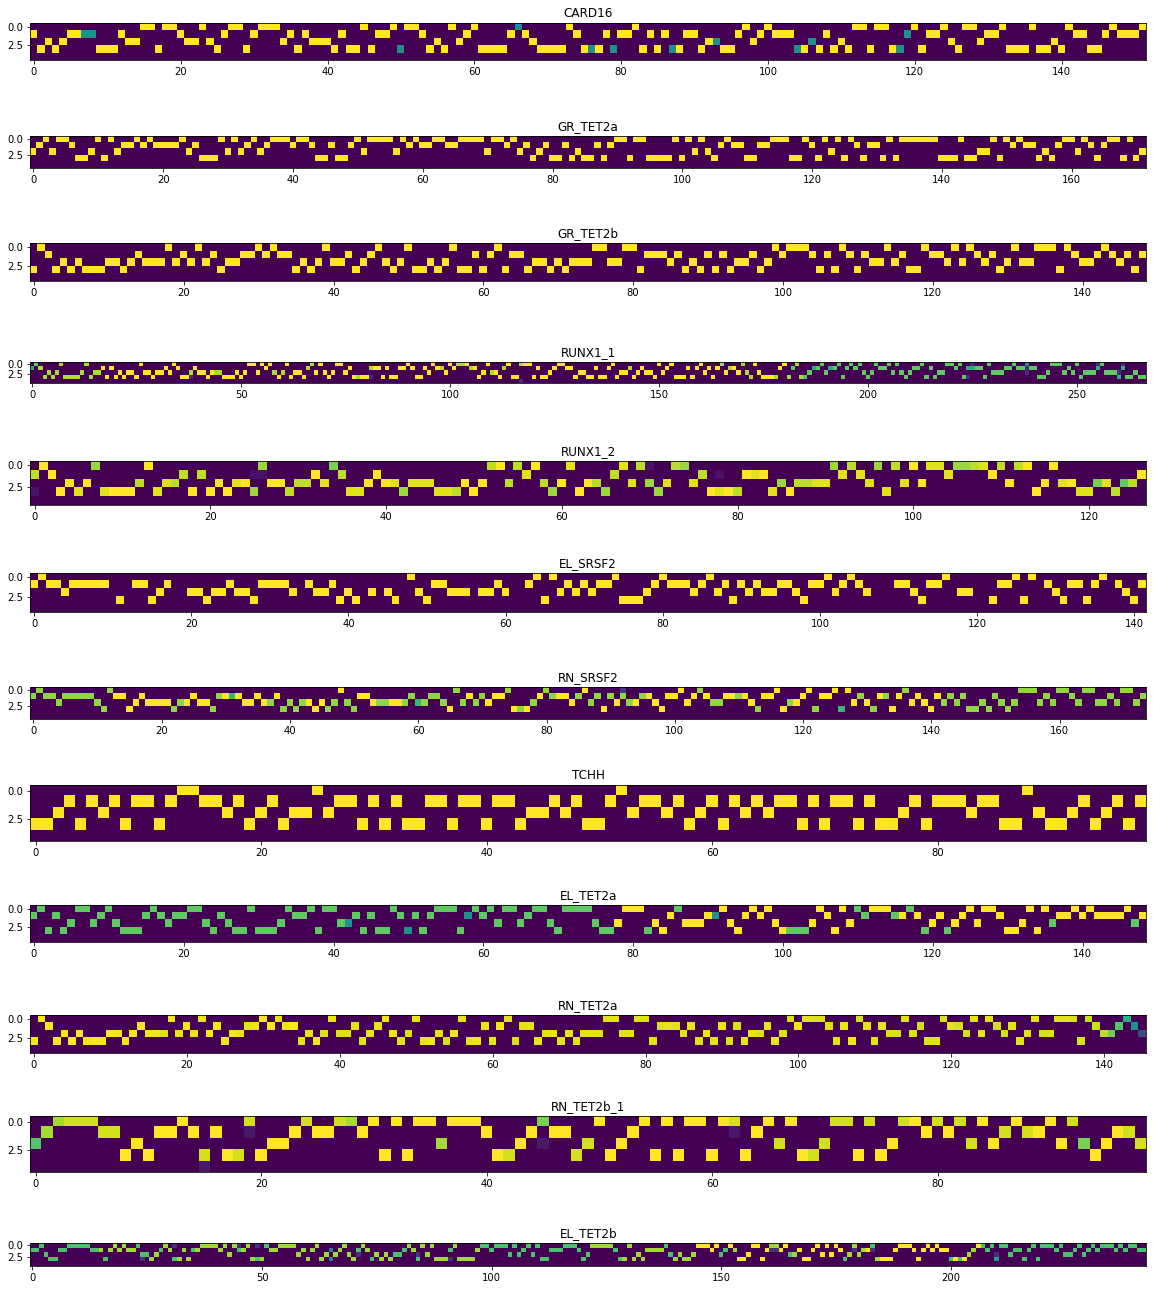

In [367]:
fig, axs = plt.subplots(len(dfs), 1, figsize = (20, 2*len(dfs)))

for key, ax in zip(dfs, axs):
    ax.imshow(dfs[key].T)
    ax.set_title(key)

<ipython-input-368-153666600890>:8: RuntimeWarning: invalid value encountered in long_scalars
  var = (1 - (dfs[key].loc[row].max() / dfs[key].loc[row].sum()))*1000


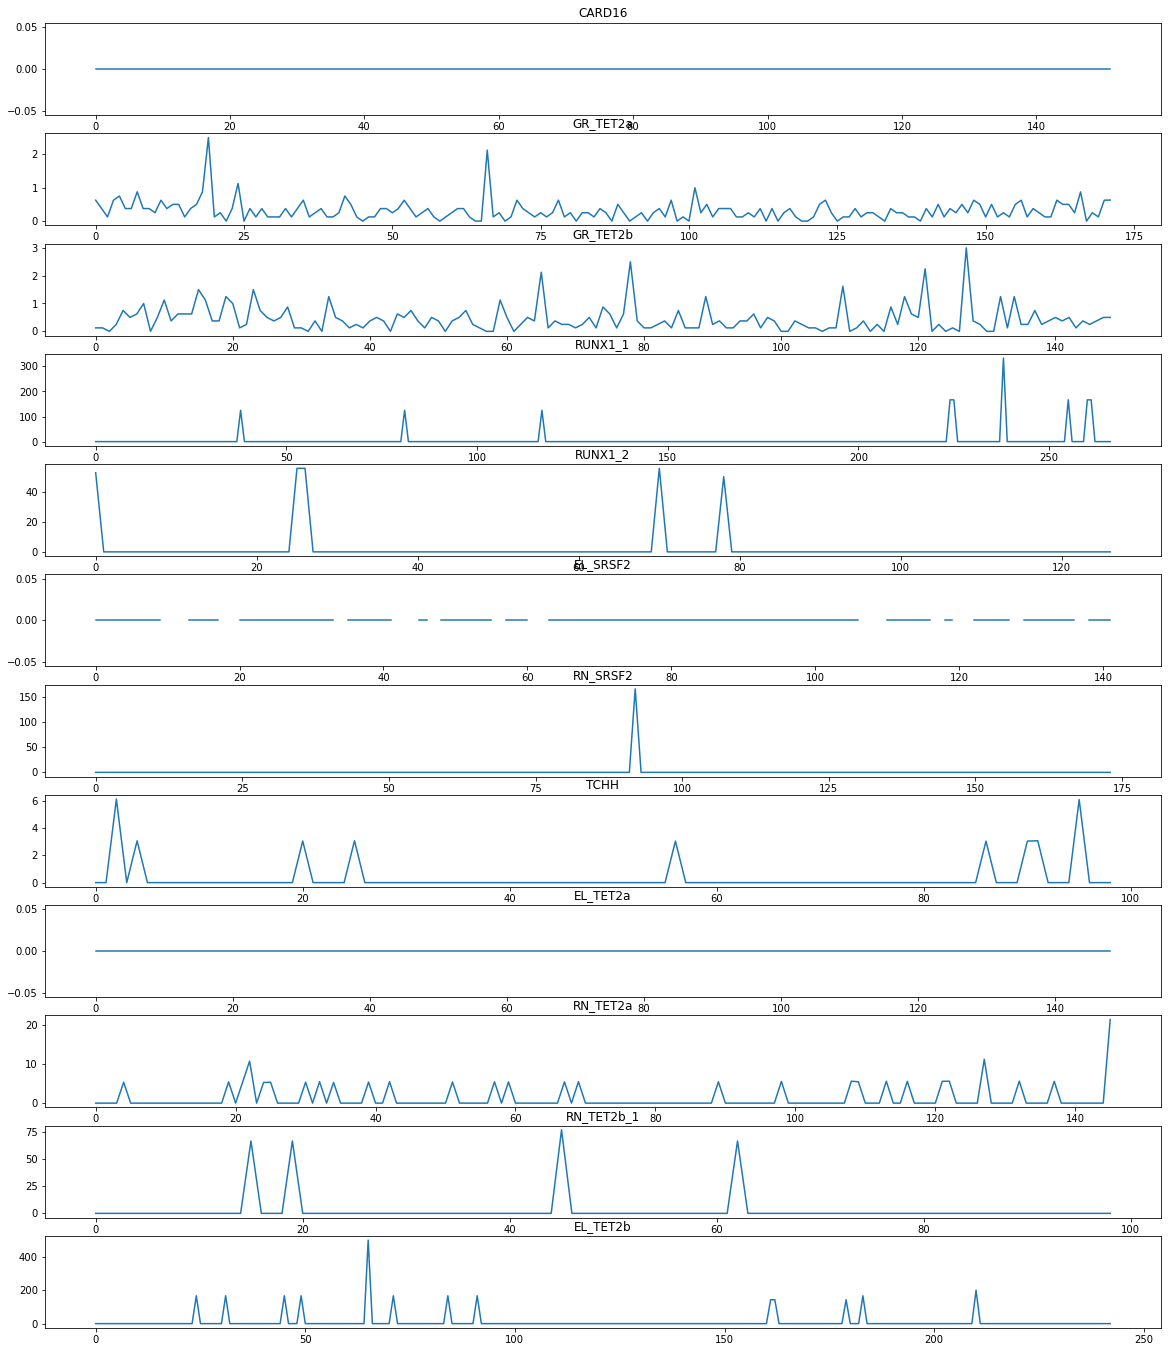

In [368]:
# permille of reads deviant from the major-letter at each position

variances = {}

for key in dfs:
    variances[key] = []
    for row in dfs[key].index:
        var = (1 - (dfs[key].loc[row].max() / dfs[key].loc[row].sum()))*1000
        variances[key].append(var)


fig, axs = plt.subplots(len(dfs), 1, figsize = (20, 2*len(dfs)))

for key, ax in zip(variances, axs):
    ax.plot(range(len(variances[key])), variances[key])
    ax.set_title(key)

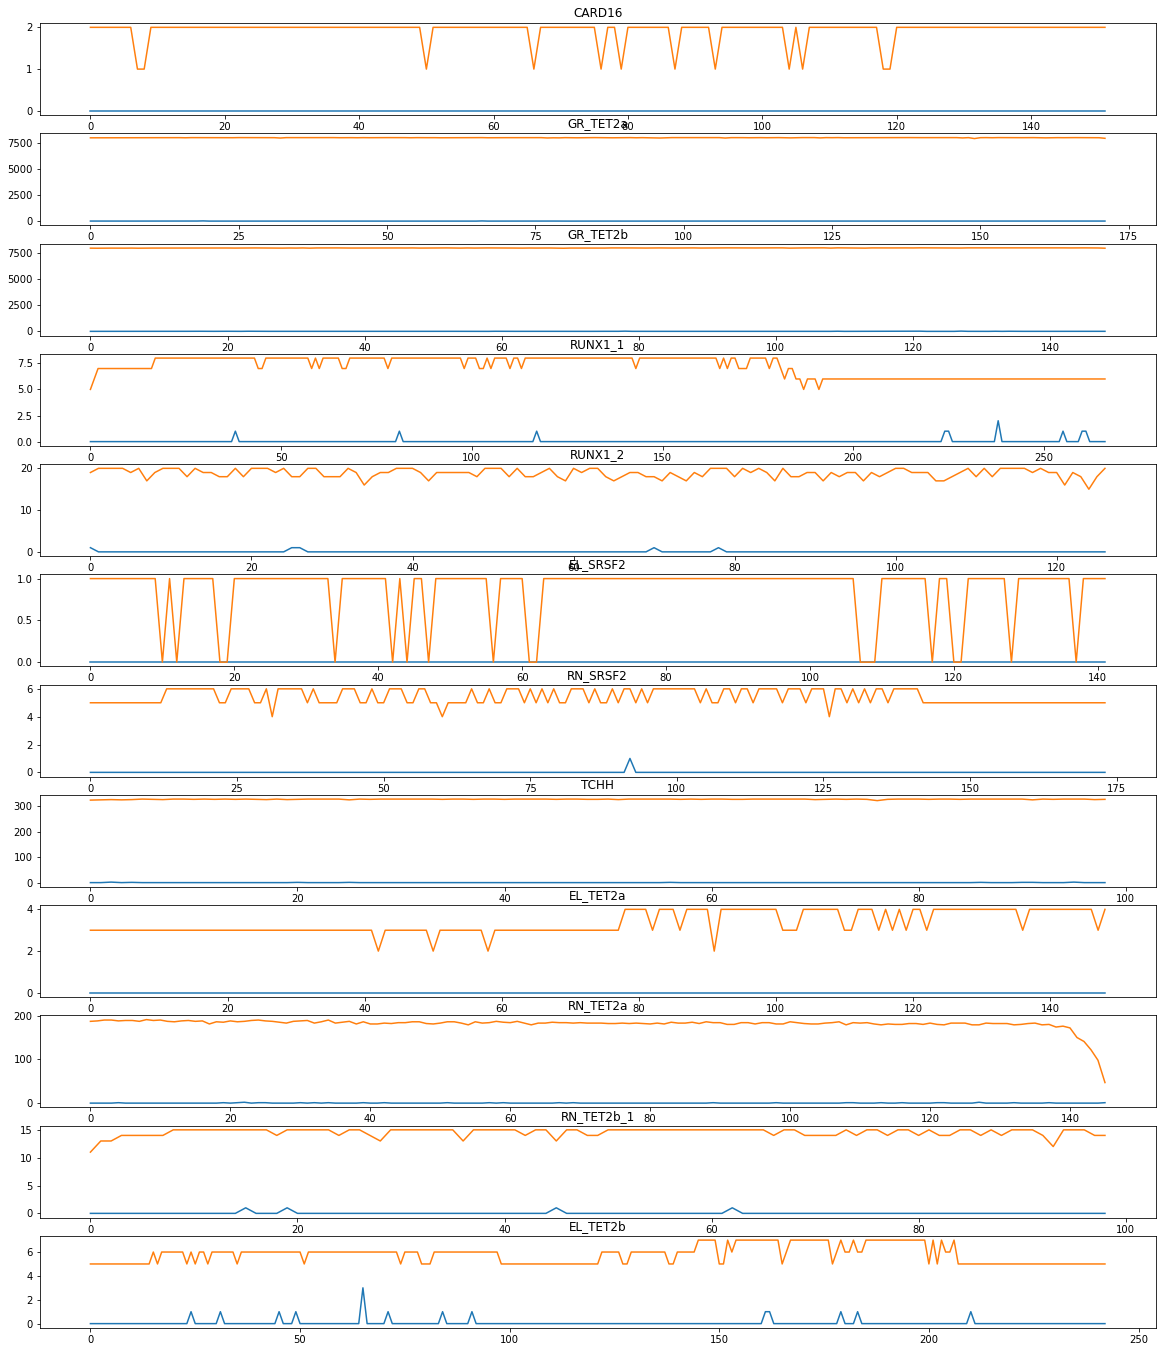

In [369]:
variances = {}
maximums = {}

for key in dfs:
    variances[key] = []
    maximums[key] = []
    for row in dfs[key].index:
        var = (dfs[key].loc[row].sum() - dfs[key].loc[row].max())
        variances[key].append(var)
        maximums[key].append(dfs[key].loc[row].sum())


fig, axs = plt.subplots(len(dfs), 1, figsize = (20, 2*len(dfs)))

for key, ax in zip(variances, axs):
    ax.plot(range(len(variances[key])), variances[key])
    ax.plot(range(len(variances[key])), maximums[key])
    ax.set_title(key)


In [370]:
for key in dfs:
    print(key)
    print("mean number of divergent base-call:")
    ((dfs[key].sum(1) - dfs[key].max(1))/dfs[key].sum(1)).mean()
    print(((dfs[key].sum(1) - dfs[key].max(1))/dfs[key].sum(1)).mean()*1000)



CARD16
mean number of divergent base-call:
0.0
GR_TET2a
mean number of divergent base-call:
0.3099683434731085
GR_TET2b
mean number of divergent base-call:
0.4513755058029991
RUNX1_1
mean number of divergent base-call:
5.774032459425718
RUNX1_2
mean number of divergent base-call:
2.120458626882166
EL_SRSF2
mean number of divergent base-call:
0.0
RN_SRSF2
mean number of divergent base-call:
0.9578544061302682
TCHH
mean number of divergent base-call:
0.3389457588749647
EL_TET2a
mean number of divergent base-call:
0.0
RN_TET2a
mean number of divergent base-call:
1.2276646798136623
RN_TET2b_1
mean number of divergent base-call:
2.797202797202797
EL_TET2b
mean number of divergent base-call:
10.131295316480502


In [371]:
for key in dfs:
    dfs[key]["allele"] = key
    dfs[key].reset_index(drop = False, inplace = True)

GR_df = pd.concat(dfs.values(), axis = 0, ignore_index = True)

In [372]:
patient

'GR'

In [377]:
GR_df["patient"] = "GR"
GR_df

,index,A,C,G,T,,allele,patient
0,0,0,2,0,0,0,CARD16,GR
1,1,0,0,0,2,0,CARD16,GR
2,2,0,0,2,0,0,CARD16,GR
3,3,0,0,0,2,0,CARD16,GR
4,4,0,0,2,0,0,CARD16,GR
...,...,...,...,...,...,...,...,...
1914,238,0,5,0,0,0,EL_TET2b,GR
1915,239,5,0,0,0,0,EL_TET2b,GR
1916,240,5,0,0,0,0,EL_TET2b,GR
1917,241,0,5,0,0,0,EL_TET2b,GR


In [378]:
EL_df["patient"] = "RN"

In [379]:
RN_df["patient"] = "RN"

In [381]:
all_pileup = pd.concat([EL_df, RN_df, GR_df], axis = 0, ignore_index = True)

In [382]:
pwd

'/home/yevel/Projects/AU_research/merge_reads/code'

In [383]:
all_pileup.to_csv("../data/results/all_patients_pileup.csv")

In [ ]:
need mpileup!!!